In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [211]:
import numpy as np
import pandas as pd

from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq,
    Poly,
    together,
    eye,
    Inverse
)

from sympy.printing.latex import print_latex
from sympy import init_printing
init_printing() 


from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

from pymad_hzb.PlotTools import new_plot_elems_madx

In [267]:
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder,  
    HamDrift4D,
    HamDipole6D,
    HamDipole6DParaxialSecondOrder,
    HamDipole4D,
    HamQuad6D,
    HamQuad4D,
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSQuad6D,
    HamSQuad6DParaxialSecondOrder,
    HamSext6D,
    HamSext4D,
    HamRFTM0106D,
    HamRFTM0106DAvg,
    HamRFTM0106DAvgParaxialSecondOrder,
    HamSolenoid6D,
    HamSolenoid6DparaxialSecondOrder,
    HamCombBend6DParaxialSecondOrder
)

from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbDrift6D,
    RsymbDrift4D,
    RsymbDipole6D,
    RsymbDipole4D,
    RsymbDipoleFringe,
    RsymbDipoleComb,
    RsymbDipoleSmallAngle,
    RMsymbDipoleComb, # extra constant 6D vector - map is of the form Rx+M
    RsymbQuad6D, 
    RsymbQuad4D,
    RsymbQuad6DChroma, 
    RsymbSQuad6D,
    RsymbQuad6DThin,
    RsymbRFTM0106D,
    RMsymbRFTM0106D, # extra constant 6D vector - map is of the form Rx+M
    RsymbSolenoid,
    RsymbFODO
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpDrift6D,
    RnpDrift4D,
    RnpDipole6D,
    RnpDipole4D,
    RnpDipoleComb,
    RMnpDipoleComb,
    RnpDipoleFringe,
    RnpQuad6D,
    RnpQuad4D,
    RnpQuad6DChroma,
    RnpSQuad6D,
    RnpQuad6DThin,
    RnpRFTM0106D,
    RMnpRFTM0106D,
    RnpSolenoid,
    RnpFODO
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.Matrices.OpticalFunctions import CosPhi, SinPhiOver2, SinPhi, CSBeta, CSAlpha, symbCSBeta, symbCSAlpha
from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick, fixedpoints2D

In [39]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f, k1s = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f k_{1s}', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)
fd, ff = symbols("f_D f_F")

# Doublet

Let's consider a doublet system. This system has the form
$$QF-O-QD$$

with ${f_F}$ and $-{f_D}$ as the focal length of the two quadrupoles
and a drift of length $L$ between them. 

**Assumption:**  $f_F$ and $f_D$ are positive numbers

The linear 2D transfer matrix is then given by:
\begin{equation}
M_{db}=
\begin{pmatrix}
1 & 0\\
-\frac{1}{f_D} & 1
\end{pmatrix}
\begin{pmatrix}
1 & L\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0\\
\frac{1}{f_F} & 1
\end{pmatrix}
\end{equation}

## 6D transfer matrix for the doublet

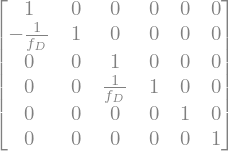

In [107]:
RsymbQuad6DThin(L,1/(L*fd))

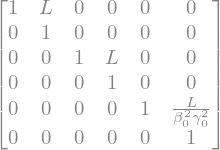

In [108]:
 RsymbDrift6D(beta0,gamma0,L)

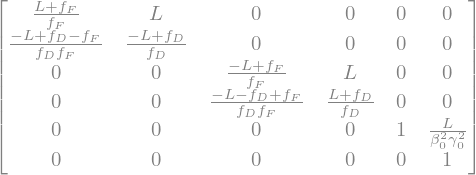

In [109]:
Mdb = simplify(RsymbQuad6DThin(L,1/(L*fd)) * RsymbDrift6D(beta0,gamma0,L) * RsymbQuad6DThin(L,-1/(L*ff)))
Mdb

This reduces to the matrix below when both focal lengths are put equal.

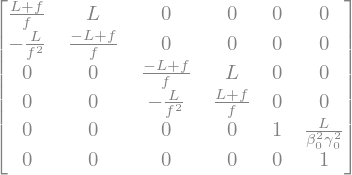

In [110]:
subdb0 = list(zip([fd,ff],[f,f]))
Mdb0 = Mdb.subs(subdb0)
Mdb0

## Generating a numeric matrix for simple tracking

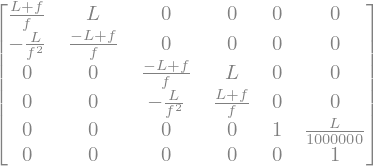

In [111]:
subdb1 = list(zip([beta0,gamma0],[1,1000]))
Mdb1 = Mdb0.subs(subdb1)
Mdb1

In [112]:
# create a numpy function
Mdbnp = lambdify((L,f),Mdb1.subs(subdb),"numpy")

## Generate a coordinate grid of 6D vectors to track

In [113]:
dim = 6
npoints = 2
coordinate_grid =GenerateNDimCoordinateGrid(dim,npoints)# GenerateNDimCoordinateGrid(dim,npoints,man_ranges={'0':np.array([1e-6,1e-5]),'1':[0]})

Shape: (6, 2, 2, 2, 2, 2, 2) - Number of paritcles: 64 


## Tracking and Plotting

Track for 100 turns all the particles in the grid.

In [114]:
nturns = 100
Y = list(nestList(LinMap, coordinate_grid.reshape(6,coordinate_grid.size//6), nturns,R = Mdbnp(1,10)))

<IPython.core.display.Javascript object>


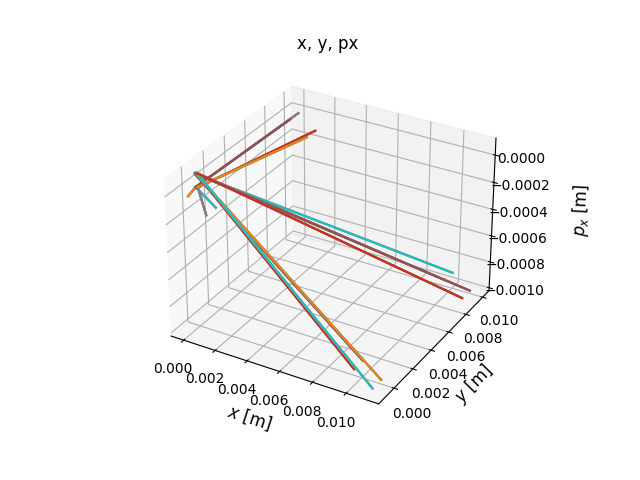

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(64):
    ax.plot( [Y[t][0,i] for t in plotturns], [Y[t][2,i] for t in plotturns], [Y[t][1,i] for t in plotturns])
ax.set_xlabel(r'$x$ [m]',fontsize=12);
ax.set_ylabel(r'$y$ [m]',fontsize=12);
ax.set_zlabel("\n"+ r'$p_x$ [m]',fontsize=12, linespacing=4);
plt.title("x, y, px");

<IPython.core.display.Javascript object>


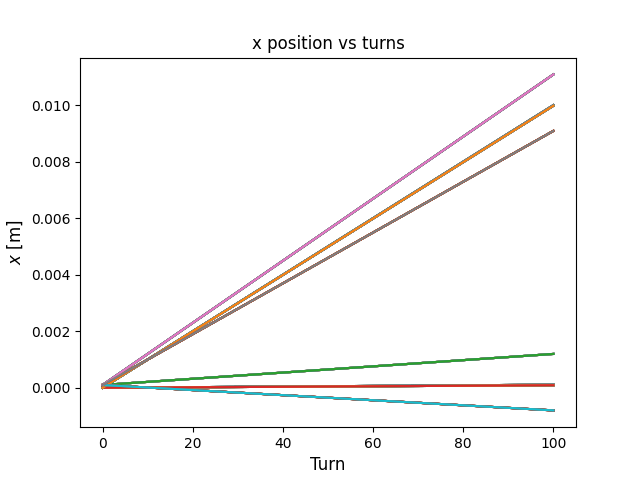

In [116]:
fig = plt.figure()
for i in range(64):# range(coordinate_grid.size//6):
    plotturns = range(nturns+1)
    plt.plot(plotturns, [Y[t][0,i] for t in plotturns])
    plt.plot(plotturns, [Y[t][2,i] for t in plotturns])
plt.xlabel('Turn',fontsize=12)
plt.ylabel(r'$x$ [m]',fontsize=12);
plt.title("x position vs turns");

# FODO

The FODO cell is a configuration of magnets that is of widely used, both for educational purposes and in real machines.  The cell consists of only two quadrupoles and two dipoles or simple drifts between quads.  
To make a symmetric cell, we use the following sequence:
$$\frac{1}{2}\text{QF}-\text{O}-\text{QD}-\text{O}-\frac{1}{2}\text{QF}$$


We use the following approximation:
* We assume the drift space, of length $L_1$, to be in the paraxial approximation at second order - put differently we assume the drift to be linear but do take into account the contributions coming from R56 (dispersive effect). 
* Quadrupole thin lense approximation, so that the quad can be modeled by its focusing length $f$
* Focusing length and defocusing length are same.

Then the matrix is
\begin{equation}
M_{FODO}=
\begin{pmatrix}
1 & 0\\
-\frac{1}{2f} & 1
\end{pmatrix}
\begin{pmatrix}
1 & L_1\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0\\
\frac{1}{f} & 1
\end{pmatrix}
\begin{pmatrix}
1 & L_1\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0\\
-\frac{1}{2f} & 1
\end{pmatrix}
\end{equation}

## 6D Transfer Matrix

### At Midpoint QF

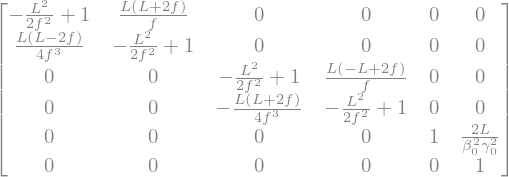

In [117]:
simplify(RsymbQuad6DThin(L,1/(2*L*f)) * RsymbDrift6D(beta0,gamma0,L) * RsymbQuad6DThin(L,-1/(L*f))* RsymbDrift6D(beta0,gamma0,L) * RsymbQuad6DThin(L,1/(2*L*f)))

This matrix is also directly available in the package.

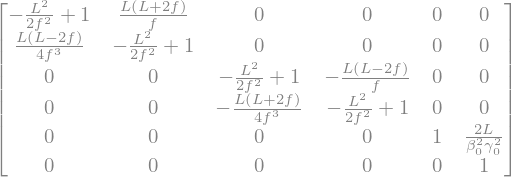

In [119]:
RsymbFODO(beta0, gamma0, L, f)

## At Midpoint QD

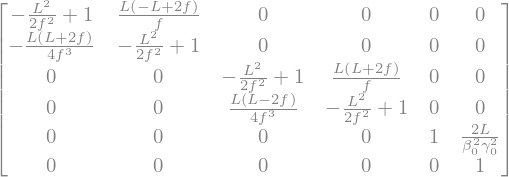

In [126]:
Mfodomid = simplify(RsymbQuad6DThin(L,-1/(2*L*f)) * RsymbDrift6D(beta0,gamma0,L) * RsymbQuad6DThin(L,1/(L*f))* RsymbDrift6D(beta0,gamma0,L) * RsymbQuad6DThin(L,-1/(2*L*f)))
Mfodomid

## Repeated cell

We focus on the x-px plane for the discussion below.


In order for the FODO cell structure in a repeating structure to be stable, the trace of the map has to be larger than $-1$.  Hence:
$$- \frac{L_{1}^{2}}{2 f^{2}} + 1 > -1 $$
which reduces to:
$$L_1<2f$$

Using the FODO map matrix representation, we can derive the optics parameters of the one-turn matrix:
$$
M=\left(\begin{array}{cc}
\cos\Phi+\alpha\sin\Phi & \beta\sin\Phi\\
-\gamma\sin\Phi & \cos\Phi-\alpha\sin\Phi
\end{array}\right)
$$

Then the betatron phase advance can be calculated from:
\begin{equation}
\cos{\Phi}=\frac{1}{2}\operatorname{tr}(M)=1-\frac{L_1^2}{2f^2}
\end{equation}

or 
\begin{equation}
\sin{\frac{\Phi}{2}}=\frac{L_1}{2f}
\end{equation}

The trace is an invariant under changing the starting piont, so does the phase advance.

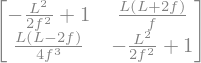

In [122]:
Mfodoxpx = RsymbFODO(beta0, gamma0, L, f)[:2,:2]
Mfodoxpx

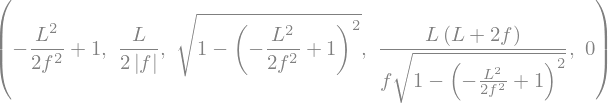

In [125]:
CosPhi(Mfodoxpx), simplify(SinPhiOver2(Mfodoxpx)),SinPhi(Mfodoxpx), CSBeta(Mfodoxpx), simplify(CSAlpha(Mfodoxpx))

## Courant-Snyder Beta extrema

The minimum occurs at the center of the QD, therefor we use the transfer matrix at the midpoint of the FODO cell. The leads for the following equation for $\beta$:
$$\beta_\text{min}(\phi) = \frac{2 - 2 \sin{\left(\frac{\phi}{2} \right)}}{\sin{\left(\phi \right)}}$$

In [169]:
phi = symbols('phi', real=True)
M = simplify(Mfodomid[:2,:2])

In [170]:
print_latex((symbCSBeta(M,phi)/L).expand().subs(L/f, 2*sin(phi/2)).collect(1/sin(phi)))

\frac{2 - 2 \sin{\left(\frac{\phi}{2} \right)}}{\sin{\left(\phi \right)}}


In [171]:
# creating a numeric function for betamin
betaminf = lambdify(phi, (symbCSBeta(M,phi)/L).expand().subs(L/f, 2*sin(phi/2)).collect(1/sin(phi)))

The maximum occurs at the center of the QF, therefor we use the transfer matrix at the endpoint of the FODO cell. The leads for the following equation for $\beta$:
$$\beta_\text{max}(\phi) = \frac{2 \left(1 - \sin{\left(\frac{\phi}{2} \right)}\right)}{\sin{\left(\phi \right)}}
$$

In [164]:
M = simplify(RsymbFODO(beta0, gamma0, L, f)[:2,:2])
betamaxf =  lambdify(phi, simplify((symbCSBeta(M,phi)/L).subs(L,2*f*sin(phi/2))))

In [173]:
 print_latex(simplify((symbCSBeta(M,phi)/L).subs(L,2*f*sin(phi/2))))

\frac{2 \left(1 - \sin{\left(\frac{\phi}{2} \right)}\right)}{\sin{\left(\phi \right)}}


<IPython.core.display.Javascript object>


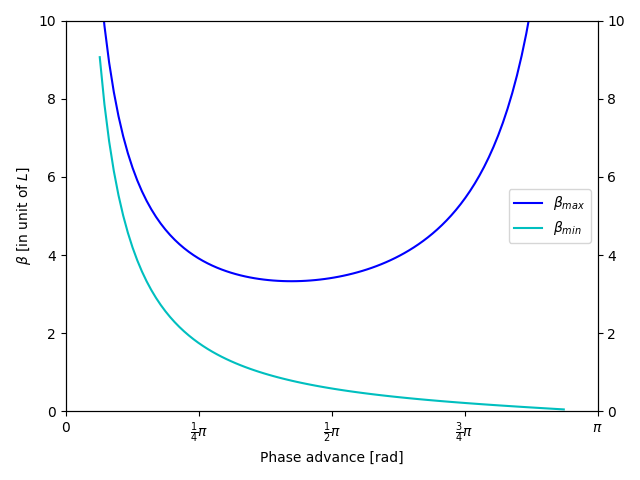

In [179]:
epsilon=0.2
phi_np=np.linspace(epsilon,np.pi-epsilon,100)

fig,ax=plt.subplots()
ax_m=ax.twinx()
ax.set_xlabel("Phase advance [rad]")
ax.set_ylabel(r"$\beta$ [in unit of $L$]")
# ax_m.set_ylabel(r"$D$ [in unit of $L\theta$]")
ax.set_ylim(0,10)
ax.set_xlim(0,np.pi)
ax_m.set_ylim(-0,10)
l1=ax.plot(phi_np,betamaxf(phi_np),c='b',label=r'$\beta_{max}$')
l2=ax.plot(phi_np,betaminf(phi_np),c='c',label=r'$\beta_{min}$')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc='right')
ax.set_xticks(np.linspace(0,1,5,)*np.pi)
ax.set_xticklabels(["$0$", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$",
                    r"$\frac{3}{4}\pi$", r"$\pi$",
                     ])

fig.tight_layout()

## Dispersion (Replace the drifts with dipoles)

In [195]:
theta = symbols("theta")

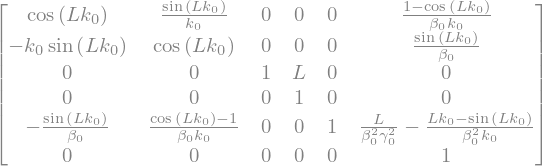

In [178]:
RsymbDipole6D(beta0,gamma0,L,k0)

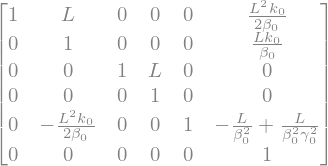

In [187]:
 RsymbDipoleSmallAngle(beta0, gamma0, L, k0)

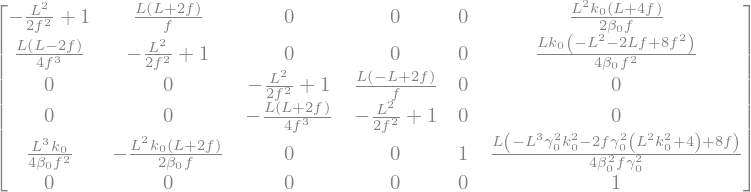

In [190]:
Mfododisp =simplify(RsymbQuad6DThin(L,1/(2*L*f)) * RsymbDipoleSmallAngle(beta0,gamma0,L,k0) * RsymbQuad6DThin(L,-1/(L*f))* RsymbDipoleSmallAngle(beta0,gamma0,L,k0) * RsymbQuad6DThin(L,1/(2*L*f)))
Mfododisp

We can again look at the middle of the QD.

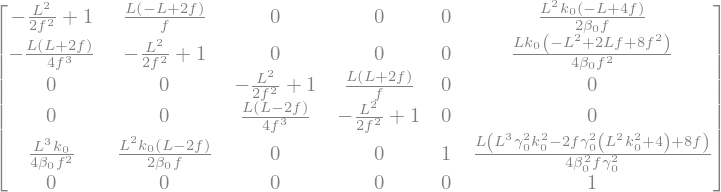

In [192]:
MfododispMid =simplify(RsymbQuad6DThin(L,-1/(2*L*f)) * RsymbDipoleSmallAngle(beta0,gamma0,L,k0) * RsymbQuad6DThin(L,1/(L*f))* RsymbDipoleSmallAngle(beta0,gamma0,L,k0) * RsymbQuad6DThin(L,-1/(2*L*f)))
MfododispMid

Remember Dispersion:
$$D = S(s) \int_0^s \frac{1}{\rho(t)}C(t)dt-C(s)\int_0^s\frac{1}{\rho(t)}S(t)dt$$

$$\begin{pmatrix}
D \\
D'
\end{pmatrix}_\text{QF}=
\begin{pmatrix}
\frac{L \theta \left(\sin{\left(\frac{\phi}{2} \right)} + 2\right)}{2 \beta_{0} \sin^{2}{\left(\frac{\phi}{2} \right)}}\\
0
\end{pmatrix}
$$

$$\begin{pmatrix}
D \\
D'
\end{pmatrix}_\text{QD}=
\begin{pmatrix}
\frac{L \theta \left(2 - \sin{\left(\frac{\phi}{2} \right)}\right)}{2 \beta_{0} \sin^{2}{\left(\frac{\phi}{2} \right)}}\\
0
\end{pmatrix}
$$

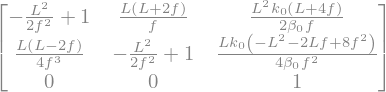

In [258]:
Mfododisp[[0,1,5],[0,1,5]]

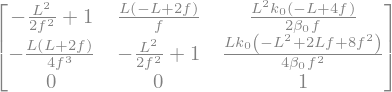

In [259]:
MfododispMid[[0,1,5],[0,1,5]]

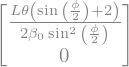

In [239]:
DQFv=together(simplify(Inverse(eye(2)-Mfododisp[:2,:2])*Mfododisp[:2,5]).subs(f,L/2/sin(phi/2)).subs(L*k0,theta).expand())
DQFv

In [240]:
print_latex(DQFv)

\left[\begin{matrix}\frac{L \theta \left(\sin{\left(\frac{\phi}{2} \right)} + 2\right)}{2 \beta_{0} \sin^{2}{\left(\frac{\phi}{2} \right)}}\\0\end{matrix}\right]


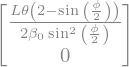

In [241]:
DQDv=together(simplify(Inverse(eye(2)-MfododispMid[:2,:2])*MfododispMid[:2,5]).subs(f,L/2/sin(phi/2)).subs(L*k0,theta).expand())
DQDv

In [242]:
print_latex(DQDv)

\left[\begin{matrix}\frac{L \theta \left(2 - \sin{\left(\frac{\phi}{2} \right)}\right)}{2 \beta_{0} \sin^{2}{\left(\frac{\phi}{2} \right)}}\\0\end{matrix}\right]


In [252]:
dispmax = lambdify(phi,(DQFv*beta0/theta/L)[0])
dispmin = lambdify(phi,(DQDv*beta0/theta/L)[0])

<IPython.core.display.Javascript object>


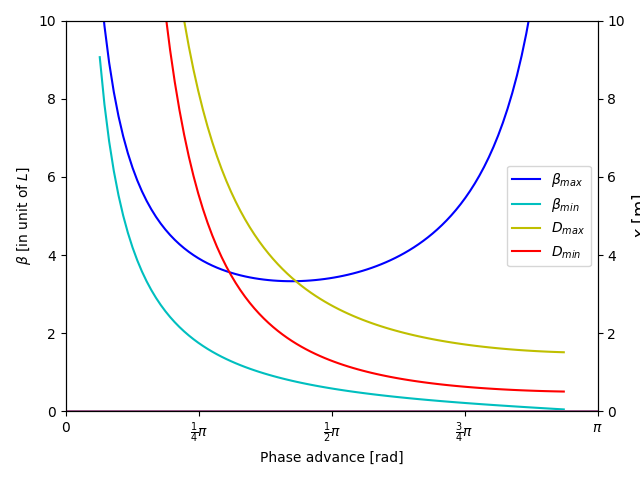

In [262]:
epsilon=0.2
phi_np=np.linspace(epsilon,np.pi-epsilon,100)

fig,ax=plt.subplots()
ax_m=ax.twinx()
ax.set_xlabel("Phase advance [rad]")
ax.set_ylabel(r"$\beta$ [in unit of $L$]")
# ax_m.set_ylabel(r"$D$ [in unit of $L\theta$]")
ax.set_ylim(0,10)
ax.set_xlim(0,np.pi)
ax_m.set_ylim(-0,10)
l1=ax.plot(phi_np,betamaxf(phi_np),c='b',label=r'$\beta_{max}$')
l2=ax.plot(phi_np,betaminf(phi_np),c='c',label=r'$\beta_{min}$')
l3=ax.plot(phi_np,dispmax(phi_np), c='y', label=r'$D_{max}$')
l4=ax.plot(phi_np,dispmin(phi_np), c='r', label=r'$D_{min}$')
lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc='right')
ax.set_xticks(np.linspace(0,1,5,)*np.pi)
ax.set_xticklabels(["$0$", r"$\frac{1}{4}\pi$", r"$\frac{1}{2}\pi$",
                    r"$\frac{3}{4}\pi$", r"$\pi$",
                     ])

fig.tight_layout()

# Simple Linear Tracking

In [263]:
Lfodo = 2
k1fodo = 1.5
gfodo = 1000
bfodo = np.sqrt(1-1/gfodo**2)
bfodo

One can now fill in values to get the actual numeric transfer matrxi, or one can apply another approximation by
$$\gamma \rightarrow \infty$$

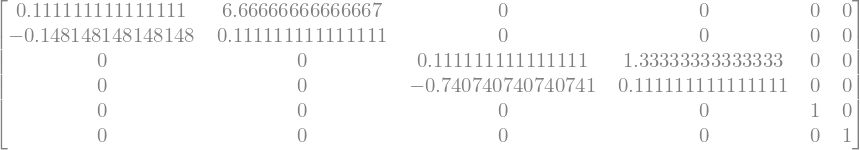

In [264]:
RsymbFODO(beta0,gamma0,L,k1).subs(beta0*gamma0,oo).subs(L,Lfodo).subs(k1,k1fodo)

We continue here with taking the $R_{56}$ term into account.

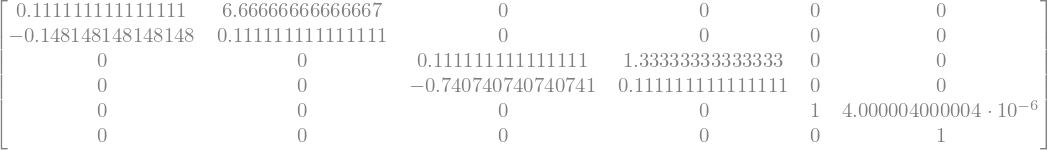

In [265]:
RsymbFODO(beta0,gamma0,L,k1).subs(beta0*gamma0,bfodo*gfodo).subs(L,Lfodo).subs(k1,k1fodo)

Get the numeric tracking matrix.

In [268]:
Rfodo = RnpFODO(bfodo,gfodo,Lfodo,k1fodo)

Generate a coordinate grid to track (for details see examples in the package).

In [269]:
dim = 6
npoints = 4
coordinate_grid = GenerateNDimCoordinateGrid(dim,npoints,man_ranges={'0':np.array([1e-6,2e-6,1e-5])})

Shape: (6, 4, 3, 4, 4, 4, 4) - Number of paritcles: 3072 


In [270]:
%%timeit
nturns = 10
Y = list(nestList(LinMap, coordinate_grid.reshape(dim,coordinate_grid.size//6),nturns,R=Rfodo))

309 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [271]:
nturns = 1000
Y = list(nestList(LinMap, coordinate_grid.reshape(6,coordinate_grid.size//6), nturns,R = Rfodo))

<IPython.core.display.Javascript object>


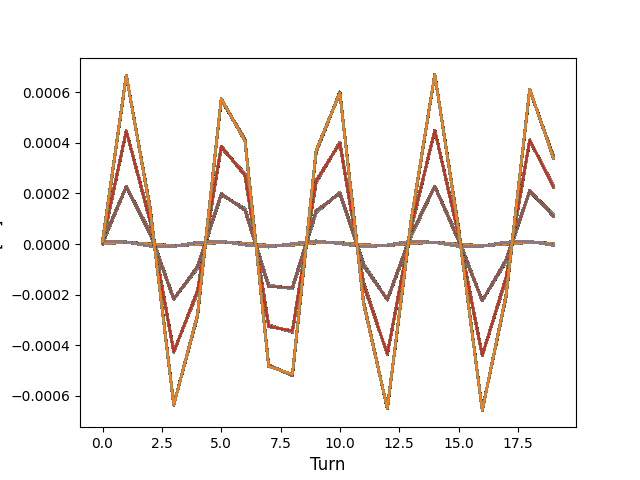

In [290]:
plt.figure()
for i in range(coordinate_grid.size//6):
    plotturns = range(20) #range(nturns+1)
    plt.plot(plotturns, [Y[t][0,i] for t in plotturns])

plt.xlabel('Turn',fontsize=12)
plt.ylabel(r'$x$ [m]',fontsize=12);

<IPython.core.display.Javascript object>


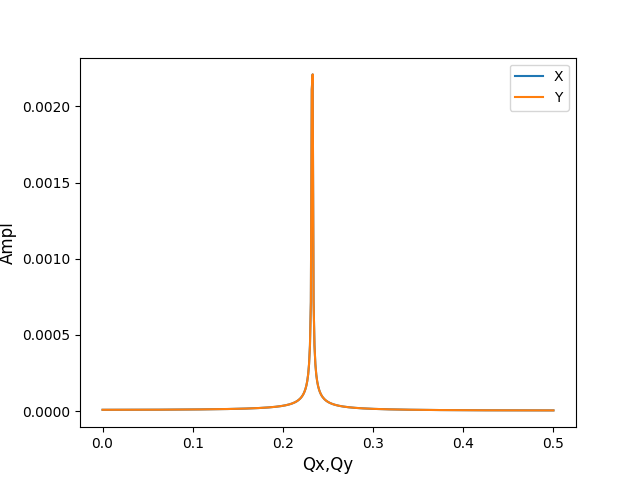

0.233 0.233


In [289]:
plt.figure()
ff = np.linspace(0, 0.5, nturns // 2 + 1)
partID = 0
XX = np.array([Y[t][0,partID] for t in range(nturns+1)])
XXf = abs(np.fft.rfft(XX))
plt.plot(ff, XXf, label="X")
partID = 25
YY = np.array([Y[t][0,partID] for t in range(nturns+1)])
YYf = abs(np.fft.rfft(YY))
q1st = ff[XXf.argmax()]
q2st = ff[YYf.argmax()]
plt.plot(ff, YYf, label="Y")
plt.xlabel("Qx,Qy", fontsize=12)
plt.ylabel("Ampl", fontsize=12)
plt.legend()
print( q1st, q2st)

<IPython.core.display.Javascript object>


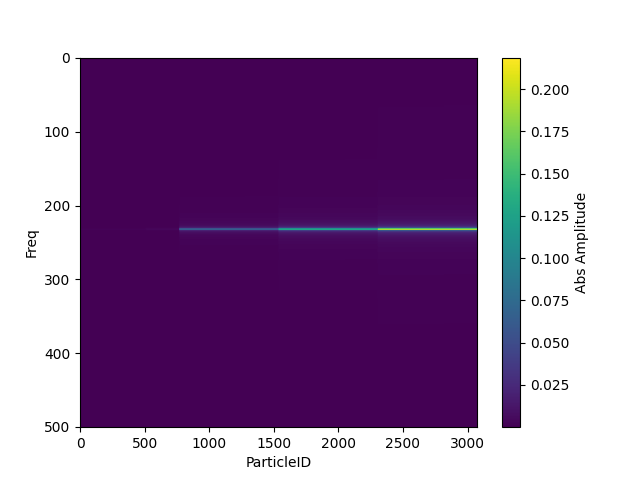

Text(0, 0.5, 'Abs Amplitude')

In [280]:
plt.figure()
XX = np.array([Y[t][:,:][0] for t in range(nturns+1)]).reshape(nturns+1, coordinate_grid.size//6)
norm = plt.cm.colors.Normalize(vmax=5*XX.max(), vmin=5*XX.min())

# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(XX, axis=0)),aspect="auto")
plt.xlabel("ParticleID")
plt.ylabel("Freq")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude")

<IPython.core.display.Javascript object>


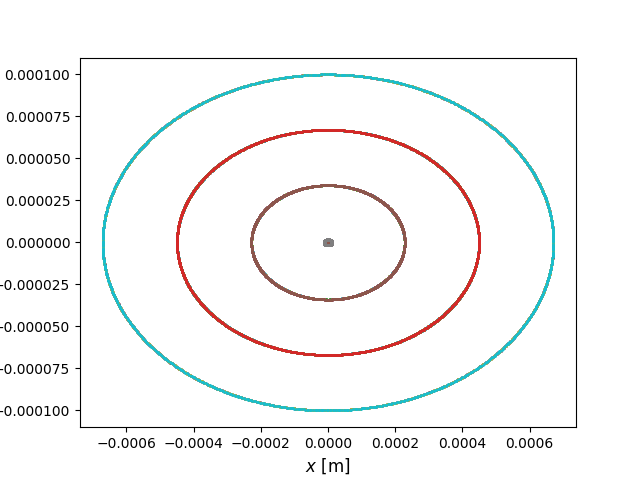

In [292]:
plt.figure()
for i in range(0,3000,100):
    plotturns = range(nturns+1)
    plt.scatter([Y[t][0,i] for t in plotturns], [Y[t][1,i] for t in plotturns],s=1)

plt.xlabel(r'$x$ [m]',fontsize=12)
plt.ylabel(r'$px$ [m]',fontsize=12);